***Incception Model with Transfer Learning***
<ul>
    <li>Load Horse or Human dataset
    <li>Create Training and Validation data generators
    <li>Create the pre-trained model
        


In [ ]:
# Install this package to use Colab's GPU for training
#!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [42]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
print("cwd: ",os.getcwd())

cwd:  C:\Users\Tom\Jupyter\TensorFlow\CNNs


***Get the already separated Train and Validation datasets***

In [4]:
# Get the Horse or Human training dataset
#!wget -P /content/ --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
#!wget  -P /content/ -q --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = 'd:/data/horse_or_human/horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('d:/data/horse_or_human/training')

val_local_zip = 'd:/data/horse_or_human/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('d:/data/horse_or_human/validation')

zip_ref.close()

In [5]:
!wget -V

GNU Wget 1.11.4

Copyright (C) 2008 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later
<http://www.gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Originally written by Hrvoje Niksic <hniksic@xemacs.org>.
Currently maintained by Micah Cowan <micah@cowan.name>.


SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc


***Review Data***

In [7]:
# Define the training and validation base directories
train_dir = 'd:/data/horse_or_human/training'
validation_dir = 'd:/data/horse_or_human/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.")

There are 500 images of horses for training.
There are 527 images of humans for training.
There are 128 images of horses for validation.
There are 128 images of humans for validation.


***Preview Data***

Sample horse image:


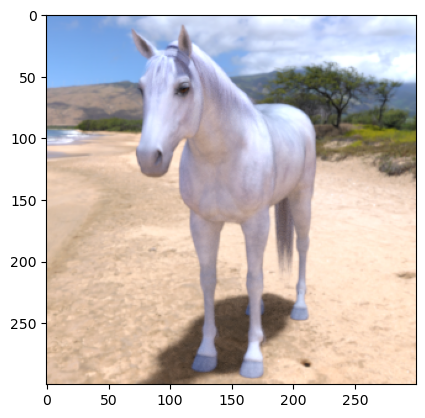



Sample human image:


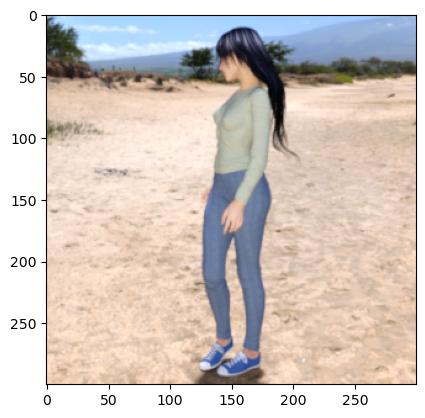

In [8]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\n\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

***Validate data type***

In [9]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


***Create Training and Validation Data Generators***
<ul><li> Reduce resolution from 300x300 to 150x150 to reduce training time


In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator: tuple containing the generators
  """
  target_size=(150,150)
  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=.2,
                                    height_shift_range=.2,
                                    shear_range=.2,
                                    zoom_range=.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=target_size)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range=0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    shear_range=0,
                                    zoom_range=0,
                                    horizontal_flip=0,
                                    fill_mode=None)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=target_size)
  ### END CODE HERE
  return train_generator, validation_generator


In [11]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

***Download the pre-trained Inception weight parameters***

In [13]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O d:/data/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2022-11-10 15:41:17--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com... 142.250.72.176, 142.250.176.16, 142.250.189.16, ...
Connecting to storage.googleapis.com|142.250.72.176|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: `d:/data/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

     0K .......... .......... .......... .......... ..........  0% 1.85M 45s
    50K .......... .......... .......... .......... ..........  0% 2.97M 37s
   100K .......... .......... .......... .......... ..........  0% 5.16M 30s
   150K .......... .......... .......... .......... ..........  0% 6.26M 26s
   200K .......... .......... .......... .......... ..........  0% 8.94M 22s

  9800K .......... .......... .......... .......... .......... 11% 15.6M 6s
  9850K .......... .......... .......... .......... .......... 11% 16.2M 6s
  9900K .......... .......... .......... .......... .......... 11% 16.7M 6s
  9950K .......... .......... .......... .......... .......... 11% 12.2M 6s
 10000K .......... .......... .......... .......... .......... 11% 17.0M 6s
 10050K .......... .......... .......... .......... .......... 11% 16.6M 6s
 10100K .......... .......... .......... .......... .......... 11% 16.8M 6s
 10150K .......... .......... .......... .......... .......... 11% 15.4M 6s
 10200K .......... .......... .......... .......... .......... 11% 15.3M 6s
 10250K .......... .......... .......... .......... .......... 11% 15.8M 6s
 10300K .......... .......... .......... .......... .......... 12% 16.0M 6s
 10350K .......... .......... .......... .......... .......... 12% 12.7M 6s
 10400K .......... .......... .......... .......... .......... 12% 17.1M 6s
 10450K ....

 24000K .......... .......... .......... .......... .......... 28% 35.5M 4s
 24050K .......... .......... .......... .......... .......... 28% 27.5M 4s
 24100K .......... .......... .......... .......... .......... 28% 42.8M 4s
 24150K .......... .......... .......... .......... .......... 28% 25.9M 4s
 24200K .......... .......... .......... .......... .......... 28% 39.2M 4s
 24250K .......... .......... .......... .......... .......... 28% 17.0M 4s
 24300K .......... .......... .......... .......... .......... 28% 68.1M 4s
 24350K .......... .......... .......... .......... .......... 28% 49.0M 4s
 24400K .......... .......... .......... .......... .......... 28% 45.7M 4s
 24450K .......... .......... .......... .......... .......... 28% 38.5M 4s
 24500K .......... .......... .......... .......... .......... 28% 35.6M 4s
 24550K .......... .......... .......... .......... .......... 28% 44.1M 4s
 24600K .......... .......... .......... .......... .......... 28% 35.9M 4s
 24650K ....

***Load the InceptionV3 model***

In [14]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'd:/data/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

***Create the Inception model with the downloaded weighting parameters.***

In [16]:
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.
  
  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file
    
  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = local_weights_file) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
        layer.trainable = False

  return pre_trained_model
  
    
pre_trained_model = create_pre_trained_model(local_weights_file)

***Review Model***

In [17]:
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

***Validate layers all set to non-trainable***

In [21]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"{total_params:,} total parameters")
print(f"{num_trainable_params:,} trainable parameters")

21,802,784 total parameters
0 trainable parameters


***Define training callbacks***

In [35]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

***Define the trained Inception model out put layer***

In [28]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model
  
  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from
    
  Returns:
    last_output: output of the model's last layer 
  """

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output


last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


***Validate the model type***

In [31]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


***Create the model***
<ul>
    <li>Output of pre-trained Inception model
    <li>Add 3 layers
    <li>Sigmoid output

In [30]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model
  
  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model
    
  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024,activation='relu')(x)
  x = layers.Dropout(.2)(x)
  x = layers.Dense(1, activation='sigmoid')(x)        


  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model


In [33]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"{total_params:,} total parameters")
print(f"{num_trainable_params:,} trainable parameters")

47,512,481 total parameters
38,537,217 trainable parameters


***Train the model***

In [36]:
# Callback halts training at 99.9% accuracy
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
17/17 - 18s - loss: 0.3526 - accuracy: 0.8919 - val_loss: 0.0144 - val_accuracy: 0.9961
Epoch 2/100
17/17 - 8s - loss: 0.0355 - accuracy: 0.9893 - val_loss: 0.0159 - val_accuracy: 0.9922
Epoch 3/100
17/17 - 7s - loss: 0.0552 - accuracy: 0.9815 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/100
17/17 - 7s - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.0390 - val_accuracy: 0.9844
Epoch 5/100
17/17 - 7s - loss: 0.0160 - accuracy: 0.9942 - val_loss: 0.0442 - val_accuracy: 0.9844
Epoch 6/100
17/17 - 8s - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.0480 - val_accuracy: 0.9805
Epoch 7/100
17/17 - 7s - loss: 0.0266 - accuracy: 0.9912 - val_loss: 0.0173 - val_accuracy: 0.9922
Epoch 8/100
17/17 - 7s - loss: 0.0048 - accuracy: 0.9981 - val_loss: 0.0463 - val_accuracy: 0.9844
Epoch 9/100
17/17 - 8s - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.0090 - val_accuracy: 0.9961

Reached 99.9% accuracy so cancelling training!


***Review Training curves***

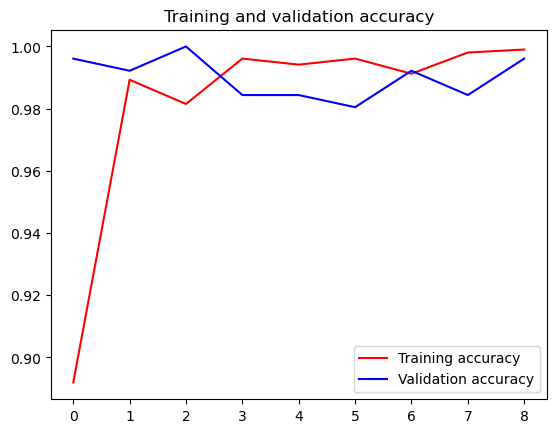

<Figure size 640x480 with 0 Axes>

In [57]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

***Get sample predictions***


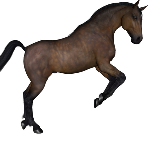

Predition: [[1.0225504e-09]]


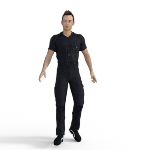

Predition: [[0.9999964]]


In [56]:
image1=load_img(os.path.join(validation_dir,'horses/horse1-264.png'), target_size=((150,150)))
image2=load_img(os.path.join(validation_dir,'humans/valhuman01-02.png'), target_size=((150,150)))
for image in [image1,image2]:
    display(image)
    imgarray=img_to_array(image)
    imgarray=imgarray.reshape(1,150,150,-1)
    imgarray /= 255.0  
    #imgarray=preprocess_input(imgarray)
    print('Predition: {}'.format(model.predict(imgarray)))